In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
import os
import glob
import codecs
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
import prepare
pd.set_option("display.max_columns", None)

In [2]:
df = pd.read_csv('ATPMain.csv')
df = prepare.prepare_atp()


In [3]:
def clean_for_model(df):

#     df = df[['tourney_id', 'draw_size', 'winner', 'surface',
#        'tourney_level', 'best_of', 'player_1', 'player_2', 'player_1_age',
#        'player_2_age', 'player_1_hand',
#        'player_2_hand', 'player_1_ht', 'player_2_ht', 'player_1_ioc', 'player_2_ioc', 'player_1_name',
#        'player_2_name', 'player_1_rank', 'player_2_rank',
#        'player_1_rank_points', 'player_2_rank_points', 'player_1_wins', 'round_ER', 'round_F', 'round_QF', 'round_R128', 'round_R16', 'round_R32', 'round_R64', 'round_RR', 'round_SF', 'player_1_hand_R', 'player_1_hand_L', 
#        'tourney_level_A', 'tourney_level_D', 'tourney_level_F', 'tourney_level_G', 'tourney_level_M', 'surface_Carpet', 'surface_Clay',
#        'surface_Grass', 'surface_Hard']].copy(0)
#     # drop null rows in specific columns
#     df = df[df.player_1_ht.notnull()]
#     df = df[df.player_2_ht.notnull()]

    # winner and loser rank columns
    df['winner_rank'] = np.where(df['winner'] == df['player_1_name'], df['player_1_rank'], df['player_2_rank'])
    df['loser_rank'] = np.where(df['winner'] == df['player_2_name'], df['player_1_rank'], df['player_2_rank'])

    # Calculate the difference in stats between player1 and playeer2. Save to new column. 
    df['ht_diff'] = df.player_1_ht - df.player_2_ht
    df['age_diff'] = df.player_1_age - df.player_2_age
    df['rank_diff'] = df.player_1_rank - df.player_2_rank
    df['rank_points_diff'] = df.player_1_rank_points - df.player_2_rank_points

    # upset column
    df['no_upset'] = df['winner_rank'] < df['loser_rank']

    # year column
    df['year'] = (df['tourney_id'].str[0:4]).astype(int)

    return df

In [4]:
df = clean_for_model(df)

In [5]:
#Player 1 is always alphabetically first - Andy
Rodrick_Federer = df[df.player_1 == 'Andy Roddick']
#Player 2 will be Roger
Rodrick_Federer = Rodrick_Federer[Rodrick_Federer.player_2 == 'Roger Federer']
Rodrick_Federer['year'] = (Rodrick_Federer['tourney_id'].str[0:4]).astype(int)
Rodrick_Federer.winner.value_counts()


Roger Federer    14
Andy Roddick      3
Name: winner, dtype: int64

In [6]:
Rodrick_Federer.year

tourney_date
2001-10-22    2001
2003-06-23    2003
2003-08-04    2003
2003-11-10    2003
2004-06-21    2004
2004-07-26    2004
2005-06-20    2005
2005-08-15    2005
2006-08-28    2006
2006-11-13    2006
2007-01-15    2007
2007-08-27    2007
2007-11-12    2007
2008-03-27    2008
2009-01-19    2009
2009-03-25    2009
2012-03-21    2012
Name: year, dtype: int64

In [7]:
def rod_fed_bar():
    years = [i for i in range(1999, 2014)]
    fedwins = [0 for i in range(1999, 2014)]
    rodwins = [0 for i in range(1999, 2014)]

    for index, row in Rodrick_Federer.iterrows():
        if row['winner'] == "Andy Roddick":
            rodwins[row['year'] - 1999] += 1
        elif row['winner'] == "Roger Federer":
            fedwins[row['year'] - 1999] += 1
    plt.figure(figsize=(12,8))

    #barwith and position
    barWidth = 0.4
    r1 = np.arange(len(fedwins))
    r2 = [x + barWidth for x in r1]

    # Make the plotdfff4f
    plt.bar(r1, fedwins, color='#3C638E', width=barWidth, edgecolor='white', label='Federer wins')
    plt.bar(r2, rodwins, color='#dfff4f', width=barWidth, edgecolor='white', label='Roddick wins')

    # Add xticks on the middle of the group bars
    plt.title('Plotting Roger Federer vs Andy Roddick over the years', fontweight='bold')
    plt.xticks([r + barWidth - 0.2 for r in range(len(fedwins))], [i for i in range(1999, 2014)])
    plt.xlabel("Year")
    plt.ylabel("# of Wins");

    # Create legend & Show graphic
    plt.legend();

In [8]:
def get_pie_wins(Rodrick_Federer):
    '''get pie chart for percent of wins'''

    # set values and labels for chart
    values = [len(Rodrick_Federer.player_1_wins[Rodrick_Federer.player_1_wins == True]), len(Rodrick_Federer.player_1_wins[Rodrick_Federer.player_1_wins == False])] 
    labels = ['Rodrick Wins','Federer Wins', ] 

    # generate and show chart
    plt.pie(values, labels=labels, autopct='%.0f%%', colors=['#dfff4f', '#3C638E'])
    plt.title('Games Ending in Federer winning Represents 1/2 of the time in the last 20 years')
    plt.show()

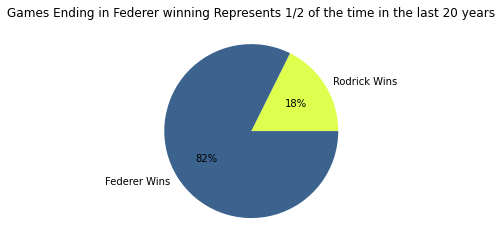

In [9]:
get_pie_wins(Rodrick_Federer)

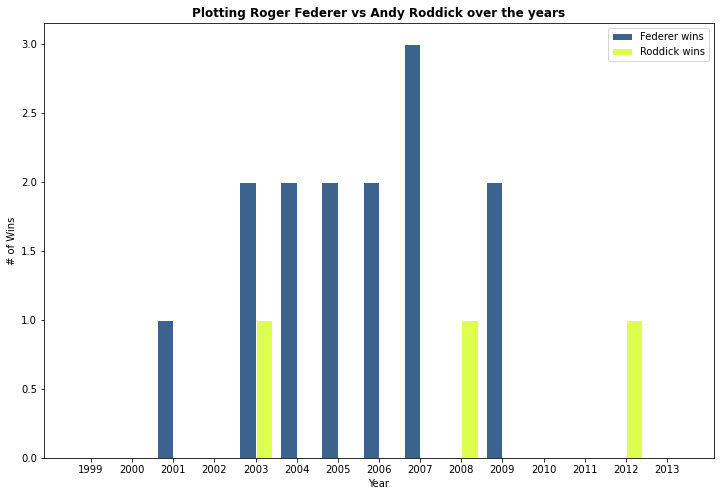

In [10]:
rod_fed_bar()

In [11]:
fed_v_rod1 = df[df.player_1.isin(['Andy Roddick']) & df.player_2.isin(['Roger Federer'])] 
Roger_Federer1 = df[df.player_1.isin(['Roger Federer'])] 
Roger_Federer2 = df[df.player_2.isin(['Roger Federer'])] 
Andy_rodray1 = df[df.player_1.isin(['Andy Roddick'])]
Andy_rodray2 = df[df.player_2.isin(['Andy Roddick'])] 

In [12]:
def get_pies_upsets(fed_v_rod1):
    "create pie charts showing upset percentage for having and not having the first move"

    # create axis object
    fig, (ax1,ax2) = plt.subplots(1,2)
    
    # create pie chart and assign to axis object
    values = [len(fed_v_rod1.no_upset[(fed_v_rod1.player_1_wins == True) & (fed_v_rod1.no_upset == True)]),
            len(fed_v_rod1.no_upset[(fed_v_rod1.player_1_wins == True) & (fed_v_rod1.no_upset == False)])]
    labels = ['Roddick Wins', 'Federer Wins']

    ax1.pie(values, labels=labels, autopct='%.0f%%', colors=['#dfff4f', '#3C638E'])
    ax1.title.set_text('High Ranked Player Wins')

    # create pie chart and and assign to axis object
    values = [len(fed_v_rod1.no_upset[(fed_v_rod1.player_1_wins == False) & (fed_v_rod1.no_upset == True)]),
            len(fed_v_rod1.no_upset[(fed_v_rod1.player_1_wins == False) & (fed_v_rod1.no_upset == False)])]
    labels = ['Roddick Wins', 'Federer Wins'] 

    ax2.pie(values, labels=labels, autopct='%.0f%%', colors=['#dfff4f', '#3C638E'])
    ax2.title.set_text('Lower Ranked Player Wins')

    # display charts
    plt.tight_layout()
    plt.show()

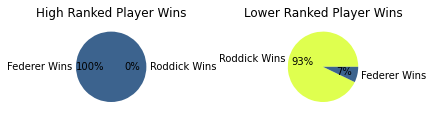

In [13]:
get_pies_upsets(fed_v_rod1)

In [14]:
def get_pie_tourney_level(fed_v_rod1):
    '''get pie chart of player win percentage for each tourney level'''

    # activate subplots objects
    fig, axs = plt.subplots(2, 2, figsize=(10,8))

    # list of charts to be generated
    levels = ['A', 'F', 'G', 'M']

    # generate graphs and assign them to subplots
    for level, ax in zip(levels, axs.ravel()):
        
        values = [len(fed_v_rod1.player_1_wins[(fed_v_rod1.player_1_wins == True) & (fed_v_rod1.tourney_level == level)]), len(fed_v_rod1.player_1_wins[(fed_v_rod1.player_1_wins == False) & (fed_v_rod1.tourney_level == level)])] 
        labels = ['Roddick Wins','Federer Wins']
        
        ax.pie(values, labels=labels, autopct='%.0f%%', colors=['#dfff4f', '#3C638E'])
        ax.set_title(f'Win Percentage for tourney {level}')
    
    # display chart
    plt.tight_layout()
    plt.show()

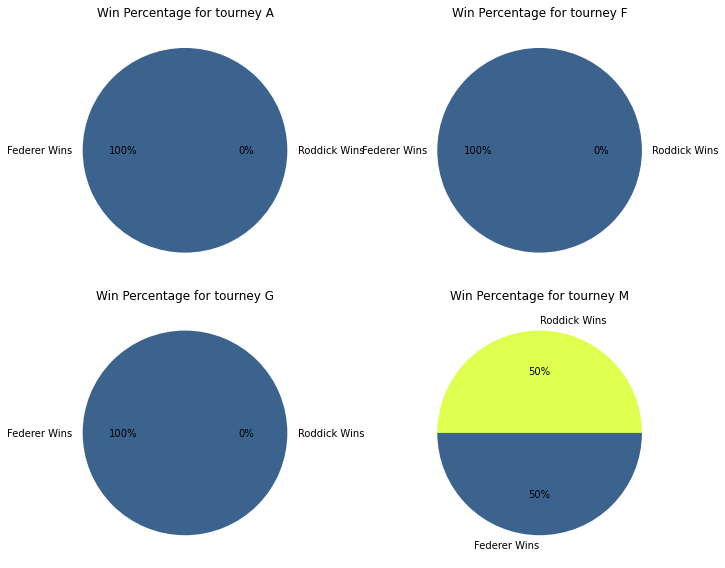

In [15]:
get_pie_tourney_level(fed_v_rod1)

In [16]:
####################################

In [17]:
from datetime import datetime

#Player 1 is always alphabetically first - Andy
Murray_Federer = df[df.player_1 == 'Andy Murray']
#Player 2 will be Roger
Murray_Federer = Murray_Federer[Murray_Federer.player_2 == 'Roger Federer']
#creating year column
Murray_Federer['year'] = (Murray_Federer['tourney_id'].str[0:4]).astype(int)

#They played 20 matches against each other
#Murray_Federer.winner.value_counts()

In [18]:
Murray_Federer.count()

tourney_id          20
tourney_name        20
surface             20
draw_size           20
tourney_level       20
                    ..
age_diff            20
rank_diff           20
rank_points_diff    20
no_upset            20
year                20
Length: 88, dtype: int64

In [19]:
def get_pie_wins(Murray_Federer):
    '''get pie chart for percent of wins'''

    # set values and labels for chart
    values = [len(Murray_Federer.player_1_wins[Murray_Federer.player_1_wins == True]), len(Murray_Federer.player_1_wins[Murray_Federer.player_1_wins == False])] 
    labels = ['Murray Wins','Federer Wins', ] 

    # generate and show chart
    plt.pie(values, labels=labels, autopct='%.0f%%', colors=['#dfff4f', '#3C638E'])
    plt.title('Games Ending in Federer winning Represents 1/2 of the time in the last 20 years')
    plt.show()

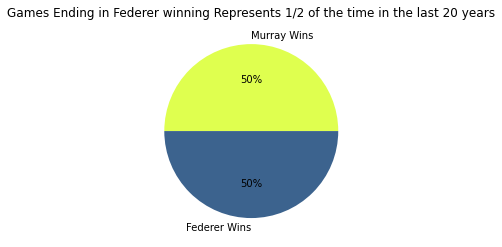

In [20]:
get_pie_wins(Murray_Federer)

In [21]:
def rod_mur_bar():
    years = [i for i in range(2004, 2017)]
    fedwins = [0 for i in range(2004, 2017)]
    murwins = [0 for i in range(2004, 2017)]

    for index, row in Murray_Federer.iterrows():
        if row['winner'] == "Andy Murray":
            murwins[row['year'] - 2004] += 1
        elif row['winner'] == "Roger Federer":
            fedwins[row['year'] - 2004] += 1
    plt.figure(figsize=(12,8))

    #barwith and position
    barWidth = 0.4
    r1 = np.arange(len(fedwins))
    r2 = [x + barWidth for x in r1]

    # Make the plot
    plt.bar(r1, fedwins, color='#3C638E', width=barWidth, edgecolor='white', label='Federer wins')
    plt.bar(r2, murwins, color='#dfff4f', width=barWidth, edgecolor='white', label='Murray wins')

    # Add xticks on the middle of the group bars
    plt.title('Plotting Roger Federer vs Andy Murray over the years', fontweight='bold')
    plt.xticks([r + barWidth - 0.2 for r in range(len(fedwins))], [i for i in range(2004, 2017)])
    plt.xlabel("Year")
    plt.ylabel("# of Wins")

    # Create legend & Show graphic
    plt.legend()

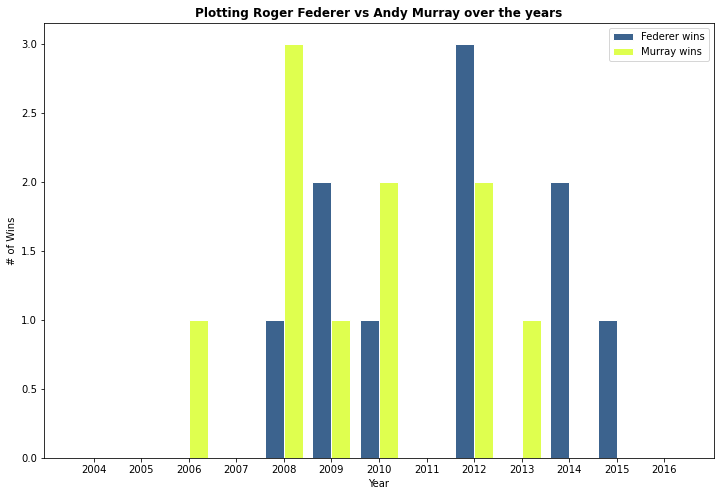

In [22]:
rod_mur_bar()

In [23]:
fed_v_mur1 = df[df.player_1.isin(['Andy Murray']) & df.player_2.isin(['Roger Federer'])] 
Roger_Federer1 = df[df.player_1.isin(['Roger Federer'])] 
Roger_Federer2 = df[df.player_2.isin(['Roger Federer'])] 
Andy_rodray1 = df[df.player_1.isin(['Andy Murray'])]
Andy_rodray2 = df[df.player_2.isin(['Andy Murray'])] 

In [24]:
def get_pies_upsets(fed_v_mur1):
    "create pie charts showing upset percentage for having and not having the first move"

    # create axis object
    fig, (ax1,ax2) = plt.subplots(1,2)
    
    # create pie chart and assign to axis object
    values = [len(fed_v_mur1.no_upset[(fed_v_mur1.player_1_wins == True) & (fed_v_mur1.no_upset == True)]),
            len(fed_v_mur1.no_upset[(fed_v_mur1.player_1_wins == True) & (fed_v_mur1.no_upset == False)])]
    labels = ['Murray Wins', 'Federer Wins']

    ax1.pie(values, labels=labels, autopct='%.0f%%', colors=['#dfff4f', '#3C638E'])
    ax1.title.set_text('High Ranked Player Wins')

    # create pie chart and and assign to axis object
    values = [len(fed_v_mur1.no_upset[(fed_v_mur1.player_1_wins == False) & (fed_v_mur1.no_upset == True)]),
            len(fed_v_mur1.no_upset[(fed_v_mur1.player_1_wins == False) & (fed_v_mur1.no_upset == False)])]
    labels = ['Murray Wins', 'Federer Wins'] 

    ax2.pie(values, labels=labels, autopct='%.0f%%', colors=['#dfff4f', '#3C638E'])
    ax2.title.set_text('Lower Ranked Player Wins')

    # display charts
    plt.tight_layout()
    plt.show()

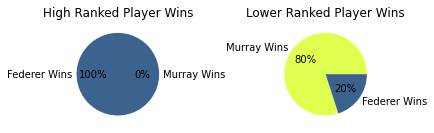

In [25]:
get_pies_upsets(fed_v_mur1)

In [26]:
def get_pie_tourney_level(fed_v_mur1):
    '''get pie chart of player win percentage for each tourney level'''

    # activate subplots objects
    fig, axs = plt.subplots(2, 2, figsize=(10,8))

    # list of charts to be generated
    levels = ['A', 'F', 'G', 'M']

    # generate graphs and assign them to subplots
    for level, ax in zip(levels, axs.ravel()):
        
        values = [len(fed_v_mur1.player_1_wins[(fed_v_mur1.player_1_wins == True) & (fed_v_mur1.tourney_level == level)]), len(fed_v_mur1.player_1_wins[(fed_v_mur1.player_1_wins == False) & (fed_v_mur1.tourney_level == level)])] 
        labels = ['Murray Wins','Federer Wins']
        
        ax.pie(values, labels=labels, autopct='%.0f%%', colors=['#dfff4f', '#3C638E'])
        ax.set_title(f'Win Percentage for tourney {level}')
    
    # display chart
    plt.tight_layout()
    plt.show()

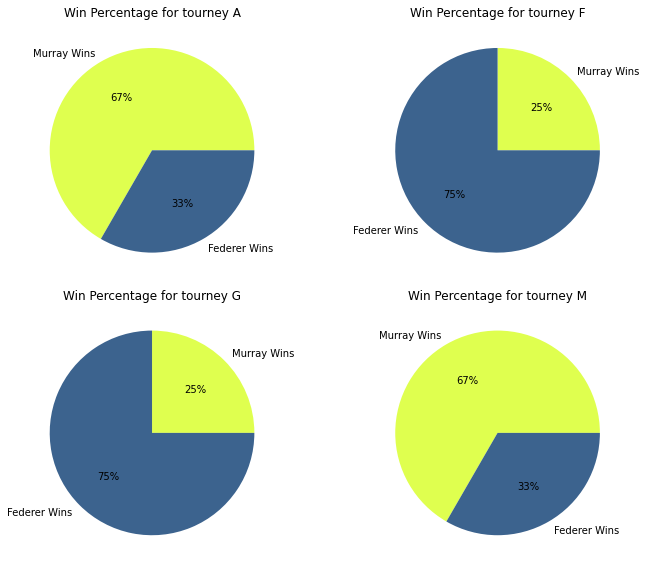

In [27]:
get_pie_tourney_level(fed_v_mur1)

In [28]:
########### NADAL AND FEDERER

In [29]:
#Player 1 is always alphabetically first - Rafae
Nadal_Federer = df[df.player_1 == 'Rafael Nadal']
#Player 2 will be Roger
Nadal_Federer = Nadal_Federer[Nadal_Federer.player_2 == 'Roger Federer']
Nadal_Federer['year'] = (Nadal_Federer['tourney_id'].str[0:4]).astype(int)


In [30]:
Nadal_Federer.count()

tourney_id          30
tourney_name        30
surface             30
draw_size           30
tourney_level       30
                    ..
age_diff            30
rank_diff           30
rank_points_diff    30
no_upset            30
year                30
Length: 88, dtype: int64

In [31]:
def rod_nad_bar():
    years = [i for i in range(2003, 2020)]
    fedwins = [0 for i in range(2003, 2020)]
    nadwins = [0 for i in range(2003, 2020)]

    for index, row in Nadal_Federer.iterrows():
        if row['winner'] == "Rafael Nadal":
            nadwins[row['year'] - 2003] += 1
        elif row['winner'] == "Roger Federer":
            fedwins[row['year'] - 2003] += 1
    plt.figure(figsize=(12,8))

    #barwith and position
    barWidth = 0.4
    r1 = np.arange(len(fedwins))
    r2 = [x + barWidth for x in r1]

    # Make the plot
    plt.bar(r1, fedwins, color='#3C638E', width=barWidth, edgecolor='white', label='Federer wins')
    plt.bar(r2, nadwins, color='#dfff4f', width=barWidth, edgecolor='white', label='Nadal wins')

    # Add xticks on the middle of the group bars
    plt.title('Plotting Roger Federer vs Rafael Nadal over the years', fontweight='bold')
    plt.xticks([r + barWidth - 0.2 for r in range(len(fedwins))], [i for i in range(2003, 2020)])
    plt.xlabel("Year")
    plt.ylabel("# of Wins");

    # Create legend & Show graphic
    plt.legend();

In [32]:
def get_pie_wins(Nadal_Federer):
    '''get pie chart for percent of wins'''

    # set values and labels for chart
    values = [len(Nadal_Federer.player_1_wins[Nadal_Federer.player_1_wins == True]), len(Nadal_Federer.player_1_wins[Nadal_Federer.player_1_wins == False])] 
    labels = ['Nadal Wins','Federer Wins', ] 

    # generate and show chart
    plt.pie(values, labels=labels, autopct='%.0f%%', colors=['#dfff4f', '#3C638E'])
    plt.title('Games Ending in Federer winning Represents 1/2 of the time in the last 20 years')
    plt.show()

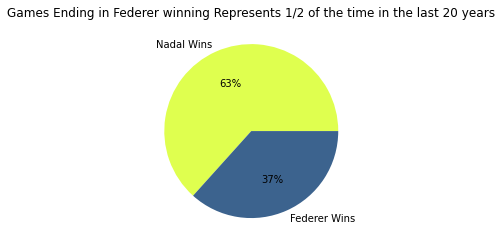

In [33]:
get_pie_wins(Nadal_Federer)

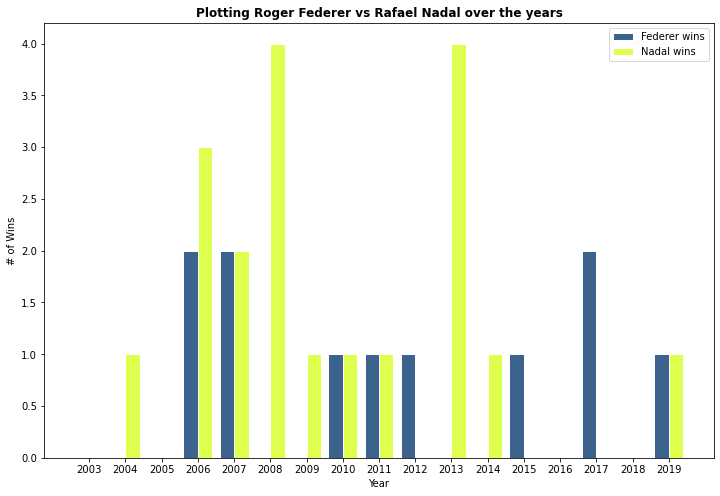

In [34]:
rod_nad_bar()

In [35]:
fed_v_nad1 = df[df.player_1.isin(['Rafael Nadal']) & df.player_2.isin(['Roger Federer'])] 
Roger_Federer1 = df[df.player_1.isin(['Roger Federer'])] 
Roger_Federer2 = df[df.player_2.isin(['Roger Federer'])] 
Andy_rodray1 = df[df.player_1.isin(['Rafael Nadal'])]
Andy_rodray2 = df[df.player_2.isin(['Rafael Nadal'])] 

In [36]:
def get_pies_upsets(fed_v_nad1):
    "create pie charts showing upset percentage for having and not having the first move"

    # create axis object
    fig, (ax1,ax2) = plt.subplots(1,2)
    
    # create pie chart and assign to axis object
    values = [len(fed_v_nad1.no_upset[(fed_v_nad1.player_1_wins == True) & (fed_v_nad1.no_upset == True)]),
            len(fed_v_nad1.no_upset[(fed_v_nad1.player_1_wins == True) & (fed_v_nad1.no_upset == False)])]
    labels = ['Nadal Wins', 'Federer Wins']

    ax1.pie(values, labels=labels, autopct='%.0f%%', colors=['#dfff4f', '#3C638E'])
    ax1.title.set_text('High Ranked Player Wins')

    # create pie chart and and assign to axis object
    values = [len(fed_v_nad1.no_upset[(fed_v_nad1.player_1_wins == False) & (fed_v_nad1.no_upset == True)]),
            len(fed_v_nad1.no_upset[(fed_v_nad1.player_1_wins == False) & (fed_v_nad1.no_upset == False)])]
    labels = ['Nadal Wins', 'Federer Wins'] 

    ax2.pie(values, labels=labels, autopct='%.0f%%', colors=['#dfff4f', '#3C638E'])
    ax2.title.set_text('Lower Ranked Player Wins')

    # display charts
    plt.tight_layout()
    plt.show()

In [37]:
def get_pie_tourney_level(fed_v_nad1):
    '''get pie chart of player win percentage for each tourney level'''

    # activate subplots objects
    fig, axs = plt.subplots(2, 2, figsize=(10,8))

    # list of charts to be generated
    levels = ['A', 'F', 'G', 'M']

    # generate graphs and assign them to subplots
    for level, ax in zip(levels, axs.ravel()):
        
        values = [len(fed_v_nad1.player_1_wins[(fed_v_nad1.player_1_wins == True) & (fed_v_nad1.tourney_level == level)]), len(fed_v_nad1.player_1_wins[(fed_v_nad1.player_1_wins == False) & (fed_v_nad1.tourney_level == level)])] 
        labels = ['Nadal Wins','Federer Wins']
        
        ax.pie(values, labels=labels, autopct='%.0f%%', colors=['#dfff4f', '#3C638E'])
        ax.set_title(f'Win Percentage for tourney {level}')
    
    # display chart
    plt.tight_layout()
    plt.show()

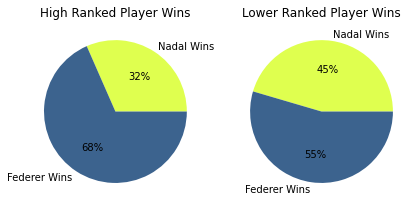

In [38]:
get_pies_upsets(fed_v_nad1)

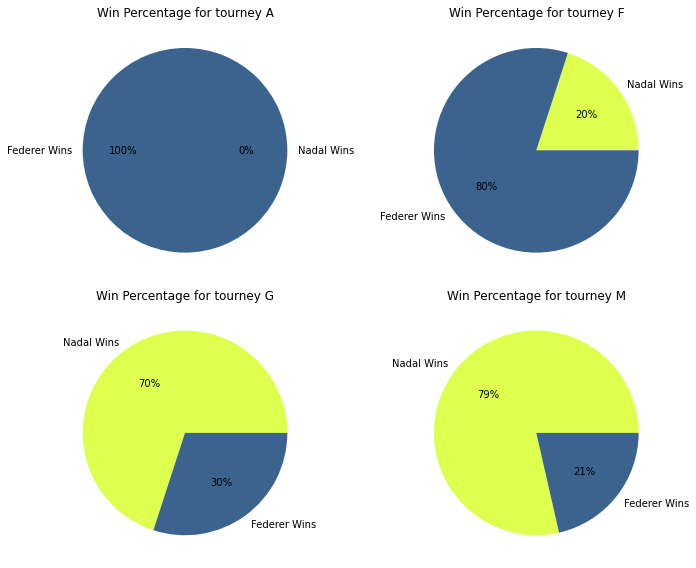

In [39]:
get_pie_tourney_level(fed_v_nad1)

In [40]:
#Player 1 is always alphabetically first - Novak
Djokovic_Federer = df[df.player_1 == 'Novak Djokovic']
#Player 2 will be Roger
Djokovic_Federer = Djokovic_Federer[Djokovic_Federer.player_2 == 'Roger Federer']
Djokovic_Federer['year'] = (Djokovic_Federer['tourney_id'].str[0:4]).astype(int)

In [41]:
Djokovic_Federer.winner.value_counts()

Novak Djokovic    21
Roger Federer     20
Name: winner, dtype: int64

In [42]:
Djokovic_Federer.winner

tourney_date
2006-04-17     Roger Federer
2007-01-15     Roger Federer
2007-02-26     Roger Federer
2007-08-27     Roger Federer
2008-01-14    Novak Djokovic
2008-04-20     Roger Federer
2008-08-25     Roger Federer
2009-03-25    Novak Djokovic
2009-04-27    Novak Djokovic
2009-08-16     Roger Federer
2009-08-31     Roger Federer
2010-08-09     Roger Federer
2010-08-30    Novak Djokovic
2010-10-10     Roger Federer
2010-11-21     Roger Federer
2011-01-17    Novak Djokovic
2011-02-21    Novak Djokovic
2011-08-29    Novak Djokovic
2012-05-13    Novak Djokovic
2012-05-27    Novak Djokovic
2012-06-25     Roger Federer
2012-08-12     Roger Federer
2012-11-05    Novak Djokovic
2013-10-28    Novak Djokovic
2013-11-04    Novak Djokovic
2014-02-24     Roger Federer
2014-03-06    Novak Djokovic
2014-04-13     Roger Federer
2014-06-23    Novak Djokovic
2014-10-05     Roger Federer
2015-02-23     Roger Federer
2015-03-12    Novak Djokovic
2015-05-10    Novak Djokovic
2015-08-16     Roger Federer
2

In [43]:
def fed_djo_bar():
    years = [i for i in range(2004, 2020)]
    fedwins = [0 for i in range(2004, 2020)]
    djowins = [0 for i in range(2004, 2020)]

    for index, row in Djokovic_Federer.iterrows():
        if row['winner'] == "Novak Djokovic":
            djowins[row['year'] - 2004] += 1
        elif row['winner'] == "Roger Federer":
            fedwins[row['year'] - 2004] += 1
    plt.figure(figsize=(12,8))

    #barwith and position
    barWidth = 0.4
    r1 = np.arange(len(fedwins))
    r2 = [x + barWidth for x in r1]

    # Make the plot
    plt.bar(r1, fedwins, color='#3C638E', width=barWidth, edgecolor='white', label='Federer wins')
    plt.bar(r2, djowins, color='#dfff4f', width=barWidth, edgecolor='white', label='Djokovic wins')

    # Add xticks on the middle of the group bars
    plt.title('Plotting Roger Federer vs Novak Djokovic over the years', fontweight='bold')
    plt.xticks([r + barWidth - 0.2 for r in range(len(fedwins))], [i for i in range(2004, 2020)])
    plt.xlabel("Year")
    plt.ylabel("# of Wins")

    # Create legend & Show graphic
    plt.legend()

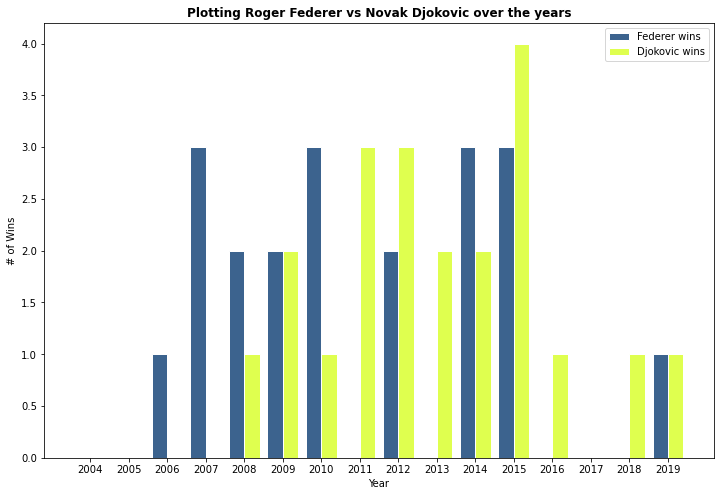

In [44]:
fed_djo_bar()

In [45]:
def get_pie_wins(Djokovic_Federer):
    '''get pie chart for percent of wins'''

    # set values and labels for chart
    values = [len(Djokovic_Federer.player_1_wins[Djokovic_Federer.player_1_wins == True]), len(Djokovic_Federer.player_1_wins[Djokovic_Federer.player_1_wins == False])] 
    labels = ['Djokovic Wins','Federer Wins', ] 

    # generate and show chart
    plt.pie(values, labels=labels, autopct='%.0f%%', colors=['#dfff4f', '#3C638E'])
    plt.title('Games Ending in Federer winning Represents 1/2 of the time in the last 20 years')
    plt.show()

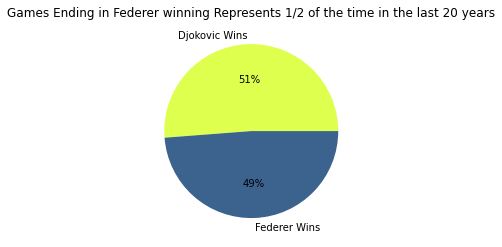

In [46]:
get_pie_wins(Djokovic_Federer)

In [47]:
fed_v_djo1 = df[df.player_1.isin(['Novak Djokovic']) & df.player_2.isin(['Roger Federer'])] 
Roger_Federer1 = df[df.player_1.isin(['Roger Federer'])] 
Roger_Federer2 = df[df.player_2.isin(['Roger Federer'])] 
Andy_djoray1 = df[df.player_1.isin(['Novak Djokovic'])]
Andy_djoray2 = df[df.player_2.isin(['Novak Djokovic'])] 

In [48]:
def get_pies_upsets(fed_v_djo1):
    "create pie charts showing upset percentage for having and not having the first move"

    # create axis object
    fig, (ax1,ax2) = plt.subplots(1,2)
    
    # create pie chart and assign to axis object
    values = [len(fed_v_djo1.no_upset[(fed_v_djo1.player_1_wins == True) & (fed_v_djo1.no_upset == True)]),
            len(fed_v_djo1.no_upset[(fed_v_djo1.player_1_wins == True) & (fed_v_djo1.no_upset == False)])]
    labels = ['Djokovic Wins', 'Federer Wins']

    ax1.pie(values, labels=labels, autopct='%.0f%%', colors=['#dfff4f', '#3C638E'])
    ax1.title.set_text('High Ranked Player Wins')

    # create pie chart and and assign to axis object
    values = [len(fed_v_djo1.no_upset[(fed_v_djo1.player_1_wins == False) & (fed_v_djo1.no_upset == True)]),
            len(fed_v_djo1.no_upset[(fed_v_djo1.player_1_wins == False) & (fed_v_djo1.no_upset == False)])]
    labels = ['Djokovic Wins', 'Federer Wins'] 

    ax2.pie(values, labels=labels, autopct='%.0f%%', colors=['#dfff4f', '#3C638E'])
    ax2.title.set_text('Lower Ranked Player Wins')

    # display charts
    plt.tight_layout()
    plt.show()

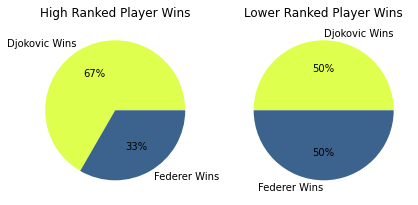

In [49]:
get_pies_upsets(fed_v_djo1)

In [50]:
def get_pie_tourney_level(fed_v_djo1):
    '''get pie chart of player win percentage for each tourney level'''

    # activate subplots objects
    fig, axs = plt.subplots(2, 2, figsize=(10,8))

    # list of charts to be generated
    levels = ['A', 'F', 'G', 'M']

    # generate graphs and assign them to subplots
    for level, ax in zip(levels, axs.ravel()):
        
        values = [len(fed_v_djo1.player_1_wins[(fed_v_djo1.player_1_wins == True) & (fed_v_djo1.tourney_level == level)]), len(fed_v_djo1.player_1_wins[(fed_v_djo1.player_1_wins == False) & (fed_v_djo1.tourney_level == level)])] 
        labels = ['Djokovic','Federer Wins']
        
        ax.pie(values, labels=labels, autopct='%.0f%%', colors=['#dfff4f', '#3C638E'])
        ax.set_title(f'Win Percentage for tourney {level}')
    
    # display chart
    plt.tight_layout()
    plt.show()

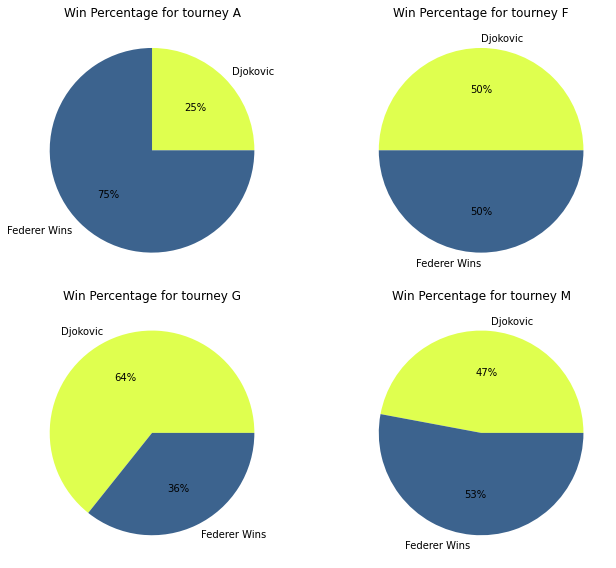

In [51]:
get_pie_tourney_level(fed_v_djo1)

In [52]:
Rodrick_Federer
Djokovic_Federer
Nadal_Federer
Murray_Federer

,tourney_id,tourney_name,surface,draw_size,tourney_level,match_num,score,best_of,round,minutes,player_1,player_2,player_1_age,player_2_age,player_1_entry,player_2_entry,player_1_hand,player_2_hand,player_1_ht,player_2_ht,player_1_id,player_2_id,player_1_ioc,player_2_ioc,player_1_name,player_2_name,player_1_rank,player_2_rank,player_1_rank_points,player_2_rank_points,player_1_seed,player_2_seed,player_1_aces,player_2_aces,player_1_double_faults,player_2_double_faults,player_1_service_points,player_2_service_points,player_1_first_serves_in,player_2_first_serves_in,player_1_first_serve_points_won,player_2_first_serve_points_won,player_1_second_serve_points_won,player_2_second_serve_points_won,player_1_service_game_total,player_2_service_game_total,player_1_break_points_saved,player_2_break_points_saved,player_1_break_points_faced,player_2_break_points_faced,winner,player_1_first_serve_%,player_2_first_serve_%,player_1_first_serve_win_%,player_2_first_serve_win_%,player_1_break_points_won,player_2_break_points_won,player_1_wins,surface_Carpet,surface_Clay,surface_Grass,surface_Hard,tourney_level_A,tourney_level_D,tourney_level_F,tourney_level_G,tourney_level_M,player_1_hand_L,player_1_hand_R,player_2_hand_L,player_2_hand_R,round_ER,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF,winner_rank,loser_rank,ht_diff,age_diff,rank_diff,rank_points_diff,no_upset,year
tourney_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-08-14,2006-422,Cincinnati Masters,Hard,64,M,33,7-5 6-4,3,R32,97.0,Andy Murray,Roger Federer,19.249829,25.015743,NaN,NaN,R,R,190.0,185.0,104918,103819,GBR,SUI,Andy Murray,Roger Federer,21.0,1.0,1210.0,7760.0,NaN,1.0,4.0,6.0,3.0,3.0,68.0,76.0,28.0,42.0,17.0,24.0,19.0,13.0,11.0,11.0,2.0,7.0,7.0,14.0,Andy Murray,0.411765,0.552632,0.607143,0.571429,7.0,5.0,True,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,21.0,1.0,5.0,-5.765914,20.0,-6550.0,False,2006
2008-03-03,2008-495,Dubai,Hard,32,A,1,6-7(6) 6-3 6-4,3,R32,115.0,Andy Murray,Roger Federer,20.802190,26.568104,NaN,NaN,R,R,190.0,185.0,104918,103819,GBR,SUI,Andy Murray,Roger Federer,11.0,1.0,1625.0,6330.0,NaN,1.0,10.0,6.0,3.0,2.0,96.0,88.0,53.0,58.0,48.0,44.0,25.0,18.0,16.0,15.0,0.0,2.0,0.0,4.0,Andy Murray,0.552083,0.659091,0.905660,0.758621,2.0,0.0,True,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,11.0,1.0,5.0,-5.765914,10.0,-4705.0,False,2008
2008-08-25,2008-560,US Open,Hard,128,G,127,6-2 7-5 6-2,5,F,111.0,Andy Murray,Roger Federer,21.281314,27.047228,NaN,NaN,R,R,190.0,185.0,104918,103819,GBR,SUI,Andy Murray,Roger Federer,6.0,2.0,2415.0,5930.0,6.0,2.0,3.0,3.0,3.0,0.0,81.0,81.0,45.0,47.0,23.0,37.0,17.0,16.0,14.0,14.0,3.0,3.0,10.0,5.0,Roger Federer,0.555556,0.580247,0.511111,0.787234,2.0,7.0,False,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,2.0,6.0,5.0,-5.765914,4.0,-3515.0,True,2008
2008-10-12,2008-1536,Madrid Masters,Hard,48,M,46,3-6 6-3 7-5,3,SF,117.0,Andy Murray,Roger Federer,21.415469,27.181383,NaN,NaN,R,R,190.0,185.0,104918,103819,GBR,SUI,Andy Murray,Roger Federer,4.0,2.0,2995.0,5930.0,4.0,2.0,14.0,7.0,2.0,1.0,86.0,98.0,53.0,65.0,45.0,46.0,17.0,18.0,15.0,15.0,2.0,7.0,3.0,9.0,Andy Murray,0.616279,0.663265,0.849057,0.707692,2.0,1.0,True,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,4.0,2.0,5.0,-5.765914,2.0,-2935.0,False,2008
2008-11-09,2008-605,Masters Cup,Hard,8,F,14,4-6 7-6(3) 7-5,3,RR,181.0,Andy Murray,Roger Federer,21.492129,27.258042,NaN,NaN,R,R,190.0,185.0,104918,103819,GBR,SUI,Andy Murray,Roger Federer,4.0,2.0,3420.0,5205.0,NaN,NaN,7.0,11.0,3.0,3.0,112.0,131.0,63.0,68.0,44.0,40.0,21.0,31.0,17.0,17.0,8.0,12.0,14.0,18.0,Andy Murray,0.562500,0.519084,0.698413,0.588235,6.0,6.0,True,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,4.0,2.0,5.0,-5.765914,2.0,-1785.0,False,2008
2009-03-12,2009-404,Indian Wells Masters,Hard,96,M,94,6-3 4-6 6-1,3,SF,108.0,Andy Murray,Roger Federer,21.817933,27.583847,NaN,NaN,R,R,190.0,185.0,104918,103819,GBR,SUI,Andy Murray,Roger Federer,4.0,2.0,7400.0,11000.0,4.0,2.0,6.0,3.0

In [53]:
# Rodrick_Federer = Rodrick_Federer.reset_index()
# Rodrick_Federer.head(1)

NameError: name 'a' is not defined

In [63]:
frames = [Rodrick_Federer, Djokovic_Federer, Nadal_Federer, Murray_Federer]
result = pd.concat(frames)
result.to_csv('Federer_Rivalries.csv')


,tourney_id,tourney_name,surface,draw_size,tourney_level,match_num,score,best_of,round,minutes,player_1,player_2,player_1_age,player_2_age,player_1_entry,player_2_entry,player_1_hand,player_2_hand,player_1_ht,player_2_ht,player_1_id,player_2_id,player_1_ioc,player_2_ioc,player_1_name,player_2_name,player_1_rank,player_2_rank,player_1_rank_points,player_2_rank_points,player_1_seed,player_2_seed,player_1_aces,player_2_aces,player_1_double_faults,player_2_double_faults,player_1_service_points,player_2_service_points,player_1_first_serves_in,player_2_first_serves_in,player_1_first_serve_points_won,player_2_first_serve_points_won,player_1_second_serve_points_won,player_2_second_serve_points_won,player_1_service_game_total,player_2_service_game_total,player_1_break_points_saved,player_2_break_points_saved,player_1_break_points_faced,player_2_break_points_faced,winner,player_1_first_serve_%,player_2_first_serve_%,player_1_first_serve_win_%,player_2_first_serve_win_%,player_1_break_points_won,player_2_break_points_won,player_1_wins,surface_Carpet,surface_Clay,surface_Grass,surface_Hard,tourney_level_A,tourney_level_D,tourney_level_F,tourney_level_G,tourney_level_M,player_1_hand_L,player_1_hand_R,player_2_hand_L,player_2_hand_R,round_ER,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF,winner_rank,loser_rank,ht_diff,age_diff,rank_diff,rank_points_diff,no_upset,year
tourney_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-10-22,2001-328,Basel,Carpet,32,A,26,3-6 6-3 7-6(5),3,QF,101.0,Andy Roddick,Roger Federer,19.145791,20.205339,NaN,NaN,R,R,188.0,185.0,104053,103819,USA,SUI,Andy Roddick,Roger Federer,16.0,13.0,1610.0,1745.0,6.0,4.0,9.0,11.0,1.0,2.0,93.0,84.0,54.0,51.0,41.0,43.0,22.0,18.0,15.0,15.0,4.0,1.0,6.0,3.0,Roger Federer,0.580645,0.607143,0.759259,0.843137,2.0,2.0,False,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,13.0,16.0,3.0,-1.059548,3.0,-135.0,True,2001
2003-06-23,2003-540,Wimbledon,Grass,128,G,125,7-6(6) 6-3 6-3,5,SF,103.0,Andy Roddick,Roger Federer,20.813142,21.872690,NaN,NaN,R,R,188.0,185.0,104053,103819,USA,SUI,Andy Roddick,Roger Federer,6.0,5.0,2390.0,2580.0,5.0,4.0,4.0,17.0,0.0,0.0,99.0,84.0,57.0,51.0,42.0,42.0,21.0,25.0,15.0,15.0,5.0,2.0,8.0,2.0,Roger Federer,0.575758,0.607143,0.736842,0.823529,0.0,3.0,False,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,5.0,6.0,3.0,-1.059548,1.0,-190.0,True,2003
2003-08-04,2003-421,Canada Masters,Hard,64,M,62,6-4 3-6 7-6(3),3,SF,116.0,Andy Roddick,Roger Federer,20.928131,21.987680,NaN,NaN,R,R,188.0,185.0,104053,103819,USA,SUI,Andy Roddick,Roger Federer,7.0,3.0,2630.0,3690.0,6.0,3.0,9.0,9.0,2.0,10.0,85.0,100.0,41.0,56.0,32.0,47.0,28.0,19.0,15.0,16.0,0.0,7.0,2.0,9.0,Andy Roddick,0.482353,0.560000,0.780488,0.839286,2.0,2.0,True,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,7.0,3.0,3.0,-1.059548,4.0,-1060.0,False,2003
2003-11-10,2003-605,Masters Cup,Hard,8,F,4,7-6(2) 6-2,3,SF,62.0,Andy Roddick,Roger Federer,21.196441,22.255989,NaN,NaN,R,R,188.0,185.0,104053,103819,USA,SUI,Andy Roddick,Roger Federer,1.0,3.0,4335.0,3625.0,NaN,NaN,5.0,12.0,1.0,2.0,63.0,56.0,46.0,31.0,34.0,27.0,6.0,19.0,10.0,10.0,0.0,0.0,2.0,0.0,Roger Federer,0.730159,0.553571,0.739130,0.870968,0.0,2.0,False,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,3.0,1.0,3.0,-1.059548,-2.0,710.0,False,2003
2004-06-21,2004-540,Wimbledon,Grass,128,G,127,4-6 7-5 7-6(3) 6-4,5,F,151.0,Andy Roddick,Roger Federer,21.809719,22.869268,NaN,NaN,R,R,188.0,185.0,104053,103819,USA,SUI,Andy Roddick,Roger Federer,2.0,1.0,4695.0,5610.0,2.0,1.0,11.0,12.0,5.0,3.0,133.0,154.0,81.0,95.0,60.0,64.0,21.0,34.0,22.0,22.0,5.0,10.0,10.0,14.0,Roger Federer,0.609023,0.616883,0.740741,0.673684,4.0,5.0,False,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1.0,2.0,3.0,-1.059548,1.0,-915.0,True,2004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [66]:
Fed_Rivalry = result
Fed_Rivalry

,tourney_id,tourney_name,surface,draw_size,tourney_level,match_num,score,best_of,round,minutes,player_1,player_2,player_1_age,player_2_age,player_1_entry,player_2_entry,player_1_hand,player_2_hand,player_1_ht,player_2_ht,player_1_id,player_2_id,player_1_ioc,player_2_ioc,player_1_name,player_2_name,player_1_rank,player_2_rank,player_1_rank_points,player_2_rank_points,player_1_seed,player_2_seed,player_1_aces,player_2_aces,player_1_double_faults,player_2_double_faults,player_1_service_points,player_2_service_points,player_1_first_serves_in,player_2_first_serves_in,player_1_first_serve_points_won,player_2_first_serve_points_won,player_1_second_serve_points_won,player_2_second_serve_points_won,player_1_service_game_total,player_2_service_game_total,player_1_break_points_saved,player_2_break_points_saved,player_1_break_points_faced,player_2_break_points_faced,winner,player_1_first_serve_%,player_2_first_serve_%,player_1_first_serve_win_%,player_2_first_serve_win_%,player_1_break_points_won,player_2_break_points_won,player_1_wins,surface_Carpet,surface_Clay,surface_Grass,surface_Hard,tourney_level_A,tourney_level_D,tourney_level_F,tourney_level_G,tourney_level_M,player_1_hand_L,player_1_hand_R,player_2_hand_L,player_2_hand_R,round_ER,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF,winner_rank,loser_rank,ht_diff,age_diff,rank_diff,rank_points_diff,no_upset,year
tourney_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-10-22,2001-328,Basel,Carpet,32,A,26,3-6 6-3 7-6(5),3,QF,101.0,Andy Roddick,Roger Federer,19.145791,20.205339,NaN,NaN,R,R,188.0,185.0,104053,103819,USA,SUI,Andy Roddick,Roger Federer,16.0,13.0,1610.0,1745.0,6.0,4.0,9.0,11.0,1.0,2.0,93.0,84.0,54.0,51.0,41.0,43.0,22.0,18.0,15.0,15.0,4.0,1.0,6.0,3.0,Roger Federer,0.580645,0.607143,0.759259,0.843137,2.0,2.0,False,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,13.0,16.0,3.0,-1.059548,3.0,-135.0,True,2001
2003-06-23,2003-540,Wimbledon,Grass,128,G,125,7-6(6) 6-3 6-3,5,SF,103.0,Andy Roddick,Roger Federer,20.813142,21.872690,NaN,NaN,R,R,188.0,185.0,104053,103819,USA,SUI,Andy Roddick,Roger Federer,6.0,5.0,2390.0,2580.0,5.0,4.0,4.0,17.0,0.0,0.0,99.0,84.0,57.0,51.0,42.0,42.0,21.0,25.0,15.0,15.0,5.0,2.0,8.0,2.0,Roger Federer,0.575758,0.607143,0.736842,0.823529,0.0,3.0,False,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,5.0,6.0,3.0,-1.059548,1.0,-190.0,True,2003
2003-08-04,2003-421,Canada Masters,Hard,64,M,62,6-4 3-6 7-6(3),3,SF,116.0,Andy Roddick,Roger Federer,20.928131,21.987680,NaN,NaN,R,R,188.0,185.0,104053,103819,USA,SUI,Andy Roddick,Roger Federer,7.0,3.0,2630.0,3690.0,6.0,3.0,9.0,9.0,2.0,10.0,85.0,100.0,41.0,56.0,32.0,47.0,28.0,19.0,15.0,16.0,0.0,7.0,2.0,9.0,Andy Roddick,0.482353,0.560000,0.780488,0.839286,2.0,2.0,True,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,7.0,3.0,3.0,-1.059548,4.0,-1060.0,False,2003
2003-11-10,2003-605,Masters Cup,Hard,8,F,4,7-6(2) 6-2,3,SF,62.0,Andy Roddick,Roger Federer,21.196441,22.255989,NaN,NaN,R,R,188.0,185.0,104053,103819,USA,SUI,Andy Roddick,Roger Federer,1.0,3.0,4335.0,3625.0,NaN,NaN,5.0,12.0,1.0,2.0,63.0,56.0,46.0,31.0,34.0,27.0,6.0,19.0,10.0,10.0,0.0,0.0,2.0,0.0,Roger Federer,0.730159,0.553571,0.739130,0.870968,0.0,2.0,False,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,3.0,1.0,3.0,-1.059548,-2.0,710.0,False,2003
2004-06-21,2004-540,Wimbledon,Grass,128,G,127,4-6 7-5 7-6(3) 6-4,5,F,151.0,Andy Roddick,Roger Federer,21.809719,22.869268,NaN,NaN,R,R,188.0,185.0,104053,103819,USA,SUI,Andy Roddick,Roger Federer,2.0,1.0,4695.0,5610.0,2.0,1.0,11.0,12.0,5.0,3.0,133.0,154.0,81.0,95.0,60.0,64.0,21.0,34.0,22.0,22.0,5.0,10.0,10.0,14.0,Roger Federer,0.609023,0.616883,0.740741,0.673684,4.0,5.0,False,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1.0,2.0,3.0,-1.059548,1.0,-915.0,True,2004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [82]:
Fed_Rivalry.winner.value_counts()

Roger Federer     55
Novak Djokovic    21
Rafael Nadal      19
Andy Murray       10
Andy Roddick       3
Name: winner, dtype: int64

In [83]:
10 + 3 + 19 + 21

53

In [77]:
def rival_bar():
    years = [i for i in range(2000, 2020)]
    fedwins = [0 for i in range(2000, 2020)]
    owins = [0 for i in range(2000, 2020)]

    for index, row in Fed_Rivalry.iterrows():
        if row['winner'] != "Roger Federer":
            owins[row['year'] - 2000] += 1
        elif row['winner'] == "Roger Federer":
            fedwins[row['year'] - 2000] += 1
    plt.figure(figsize=(12,8))

    #barwith and position
    barWidth = 0.4
    r1 = np.arange(len(fedwins))
    r2 = [x + barWidth for x in r1]

    # Make the plot
    plt.bar(r1, fedwins, color='#3C638E', width=barWidth, edgecolor='white', label='Federer wins')
    plt.bar(r2, owins, color='#dfff4f', width=barWidth, edgecolor='white', label='Rival wins')

    # Add xticks on the middle of the group bars
    plt.title('Plotting Roger Federer vs Rivals over the years', fontweight='bold')
    plt.xticks([r + barWidth - 0.2 for r in range(len(fedwins))], [i for i in range(2000, 2020)])
    plt.xlabel("Year")
    plt.ylabel("# of Wins")

    # Create legend & Show graphic
    plt.legend()

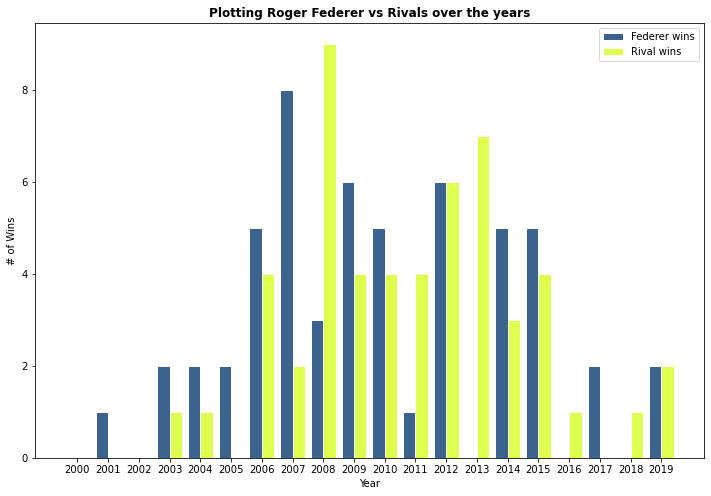

In [78]:
rival_bar()

In [84]:
def get_pie_wins_rivals():
    '''get pie chart for percent of wins'''

    # set values and labels for chart
    values = [len(Fed_Rivalry.player_1_wins[Fed_Rivalry.player_1_wins == True]), len(Fed_Rivalry.player_1_wins[Fed_Rivalry.player_1_wins == False])] 
    labels = ['Rival Wins','Federer Wins', ] 

    # generate and show chart
    plt.pie(values, labels=labels, autopct='%.0f%%', colors=['#dfff4f', '#3C638E'])
    plt.title('Games Ending in Federer winning Represents 1/2 of the time in the last 20 years')
    plt.show()

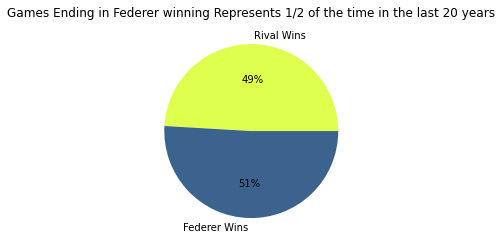

In [85]:
get_pie_wins_rivals()

In [86]:
fed_v_riv = df[df.player_1.isin([['Novak Djokovic', 'Rafael Nadal', 'Andy Murray', 'Andy Roddick ']]) & df.player_2.isin(['Roger Federer'])] 
Roger_Federer1 = df[df.player_1.isin(['Roger Federer'])] 
Roger_Federer2 = df[df.player_2.isin(['Roger Federer'])] 
Riv1 = df[df.player_1.isin([['Novak Djokovic', 'Rafael Nadal', 'Andy Murray', 'Andy Roddick ']])]
Riv1 = df[df.player_2.isin([['Novak Djokovic', 'Rafael Nadal', 'Andy Murray', 'Andy Roddick ']])] 

In [224]:
fed_v_riv

,tourney_id,tourney_name,surface,draw_size,tourney_level,match_num,score,best_of,round,minutes,player_1,player_2,player_1_age,player_2_age,player_1_entry,player_2_entry,player_1_hand,player_2_hand,player_1_ht,player_2_ht,player_1_id,player_2_id,player_1_ioc,player_2_ioc,player_1_name,player_2_name,player_1_rank,player_2_rank,player_1_rank_points,player_2_rank_points,player_1_seed,player_2_seed,player_1_aces,player_2_aces,player_1_double_faults,player_2_double_faults,player_1_service_points,player_2_service_points,player_1_first_serves_in,player_2_first_serves_in,player_1_first_serve_points_won,player_2_first_serve_points_won,player_1_second_serve_points_won,player_2_second_serve_points_won,player_1_service_game_total,player_2_service_game_total,player_1_break_points_saved,player_2_break_points_saved,player_1_break_points_faced,player_2_break_points_faced,winner,player_1_first_serve_%,player_2_first_serve_%,player_1_first_serve_win_%,player_2_first_serve_win_%,player_1_break_points_won,player_2_break_points_won,player_1_wins,surface_Carpet,surface_Clay,surface_Grass,surface_Hard,tourney_level_A,tourney_level_D,tourney_level_F,tourney_level_G,tourney_level_M,player_1_hand_L,player_1_hand_R,player_2_hand_L,player_2_hand_R,round_ER,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF,winner_rank,loser_rank,ht_diff,age_diff,rank_diff,rank_points_diff,no_upset,year
tourney_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [92]:
def get_pie_tourney_level():
    '''get pie chart of player win percentage for each tourney level'''

    # activate subplots objects
    fig, axs = plt.subplots(2, 2, figsize=(10,8))

    # list of charts to be generated
    levels = ['A', 'F', 'G', 'M']

    # generate graphs and assign them to subplots
    for level, ax in zip(levels, axs.ravel()):
        
        values = [len(fed_v_riv.player_1_wins[(fed_v_riv.player_1_wins == True) & (fed_v_riv.tourney_level == level)]), len(fed_v_riv.player_1_wins[(fed_v_riv.player_1_wins == False) & (fed_v_riv.tourney_level == level)])] 
        labels = ['Djokovic','Federer Wins']
        
        ax.pie(values, labels=labels, autopct='%.0f%%', colors=['#dfff4f', '#3C638E'])
        ax.set_title(f'Win Percentage for tourney {level}')
    
    # display chart
    plt.tight_layout()
    plt.show()

In [98]:
Fed_Rivalry.tourney_level.value_counts()

M    46
G    35
F    18
A     9
Name: tourney_level, dtype: int64

In [101]:
Fed_Rivalry.tourney_name.value_counts()

Tour Finals             12
Australian Open         11
Cincinnati Masters      10
Wimbledon               10
US Open                  9
Dubai                    6
Masters Cup              6
Miami Masters            6
Monte Carlo Masters      6
Rome Masters             5
Shanghai Masters         5
Roland Garros            5
Indian Wells Masters     5
Canada Masters           4
Hamburg Masters          2
Madrid Masters           2
Basel                    2
Paris Masters            1
London Olympics          1
Name: tourney_name, dtype: int64

In [107]:
Fed_Rivalry['round'].value_counts()

F      44
SF     40
QF      9
RR      9
R32     4
R64     1
R16     1
Name: round, dtype: int64

In [ ]:
# # Creating 4 dataframes for Grandslams
# Roland_Garros_df = df[df.tourney_name == 'Roland Garros']
# Wimbledon_df = df[df.tourney_name == 'Wimbledon']
# US_Open_df = df[df.tourney_name == 'US Open']
# Australian_Open_df = df[df.tourney_name == 'Australian Open']

In [ ]:
grand_list = ['Roland Garros', 'Wimbledon', 'US Open', 'Australian Open']
grand_df = df[df['tourney_name'].isin(grand_list)]
grand_df.shape

In [ ]:
# Creating 4 dataframes for Grandslams
Roland_Garros_Fed_Rivalry = Fed_Rivalry[Fed_Rivalry.tourney_name == 'Roland Garros']
Wimbledon_Fed_Rivalry = Fed_Rivalry[Fed_Rivalry.tourney_name == 'Wimbledon']
US_Open_Fed_Rivalry = Fed_Rivalry[Fed_Rivalry.tourney_name == 'US Open']
Australian_Open_Fed_Rivalry = Fed_Rivalry[Fed_Rivalry.tourney_name == 'Australian Open']

In [109]:
grand_list = ['Roland Garros', 'Wimbledon', 'US Open', 'Australian Open']
grand_df = Fed_Rivalry[Fed_Rivalry['tourney_name'].isin(grand_list)]
grand_df.shape

(35, 88)

In [116]:
# Finals, SF, QF
grand_df['round'].value_counts()

SF     16
F      16
QF      2
R16     1
Name: round, dtype: int64

In [119]:
#database of Grand Slam Finals with Federer
grand_winners = grand_df[grand_df['round']== 'F']


Series([], dtype: int64)

In [123]:
sf_winners = grand_df[grand_df['round']== 'SF']
sf_winners.winner.value_counts()

Roger Federer     7
Novak Djokovic    6
Rafael Nadal      2
Andy Murray       1
Name: winner, dtype: int64

In [121]:
grand_winners.winner.value_counts()

Roger Federer     8
Rafael Nadal      5
Novak Djokovic    3
Name: winner, dtype: int64

In [124]:
df.head(1)

,tourney_id,tourney_name,surface,draw_size,tourney_level,match_num,score,best_of,round,minutes,player_1,player_2,player_1_age,player_2_age,player_1_entry,player_2_entry,player_1_hand,player_2_hand,player_1_ht,player_2_ht,player_1_id,player_2_id,player_1_ioc,player_2_ioc,player_1_name,player_2_name,player_1_rank,player_2_rank,player_1_rank_points,player_2_rank_points,player_1_seed,player_2_seed,player_1_aces,player_2_aces,player_1_double_faults,player_2_double_faults,player_1_service_points,player_2_service_points,player_1_first_serves_in,player_2_first_serves_in,player_1_first_serve_points_won,player_2_first_serve_points_won,player_1_second_serve_points_won,player_2_second_serve_points_won,player_1_service_game_total,player_2_service_game_total,player_1_break_points_saved,player_2_break_points_saved,player_1_break_points_faced,player_2_break_points_faced,winner,player_1_first_serve_%,player_2_first_serve_%,player_1_first_serve_win_%,player_2_first_serve_win_%,player_1_break_points_won,player_2_break_points_won,player_1_wins,surface_Carpet,surface_Clay,surface_Grass,surface_Hard,tourney_level_A,tourney_level_D,tourney_level_F,tourney_level_G,tourney_level_M,player_1_hand_L,player_1_hand_R,player_2_hand_L,player_2_hand_R,round_ER,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF,winner_rank,loser_rank,ht_diff,age_diff,rank_diff,rank_points_diff,no_upset,year
tourney_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-01-11,1999-338,Sydney,Hard,32,A,16,7-6(1) 6-1,3,R32,84.0,Lleyton Hewitt,Patrick Rafter,17.878166,26.036961,NaN,NaN,R,R,180.0,185.0,103720,102158,AUS,AUS,Lleyton Hewitt,Patrick Rafter,104.0,4.0,456.0,3315.0,NaN,2.0,2.0,0.0,0.0,5.0,73.0,59.0,51.0,36.0,32.0,24.0,14.0,8.0,10.0,9.0,4.0,3.0,6.0,7.0,Lleyton Hewitt,0.69863,0.610169,0.627451,0.666667,4.0,2.0,True,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,104.0,4.0,-5.0,-8.158795,100.0,-2859.0,False,1999


In [187]:
df['year'] = df.year.astype(int)
df['year'].dtype

dtype('int64')

In [178]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as colors


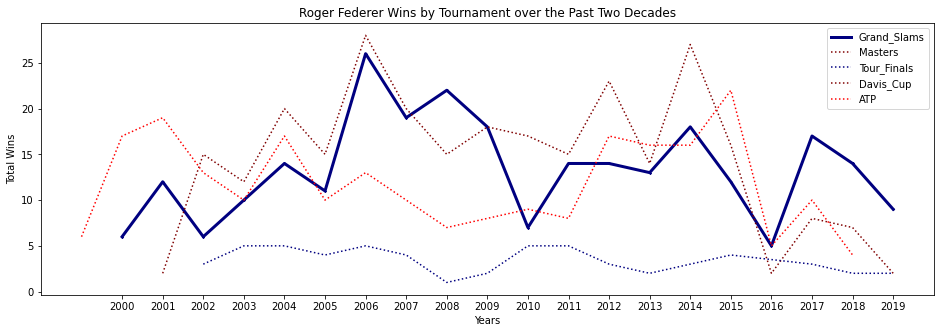

In [213]:
rf1 = df[(df['winner'] == 'Roger Federer')].groupby(['year','tourney_level'], as_index=False).agg(['count'])
rf2 = rf1['tourney_id'].reset_index()

fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(1,1,1)
#jet = cm = plt.get_cmap('jet')

ax.set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, 2, endpoint=True))))
plt.xticks(np.arange(2000, 2020))
plt.title('Roger Federer Wins by Tournament over the Past Two Decades')
plt.xlabel("Years")
plt.ylabel("Total Wins")


plt.plot(rf2[rf2['tourney_level']=='G']['year'], rf2[rf2['tourney_level']=='G']['count'], marker='*', markersize=2, linewidth=3)
plt.plot(rf2[rf2['tourney_level']=='M']['year'], rf2[rf2['tourney_level']=='M']['count'], linestyle='dotted')
plt.plot(rf2[rf2['tourney_level']=='F']['year'], rf2[rf2['tourney_level']=='F']['count'], linestyle='dotted')
plt.plot(rf2[rf2['tourney_level']=='D']['year'], rf2[rf2['tourney_level']=='D']['count'], linestyle='dotted')
plt.plot(rf2[rf2['tourney_level']=='A']['year'], rf2[rf2['tourney_level']=='A']['count'], linestyle='dotted', color = "r")
plt.legend(['Grand_Slams', 'Masters', 'Tour_Finals', 'Davis_Cup', 'ATP'], loc='upper right', prop={'size': 10});

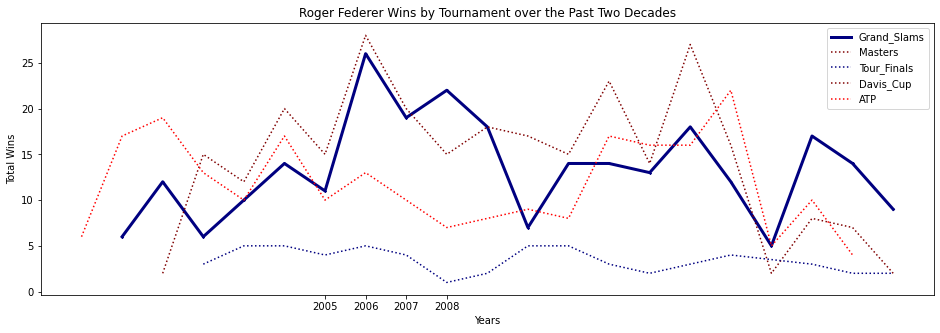

In [225]:
rf1 = df[(df['winner'] == 'Roger Federer')].groupby(['year','tourney_level'], as_index=False).agg(['count'])
rf2 = rf1['tourney_id'].reset_index()

fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(1,1,1)
#jet = cm = plt.get_cmap('jet')

ax.set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, 2, endpoint=True))))
plt.xticks(np.arange(2005, 2009))
plt.title('Roger Federer Wins by Tournament over the Past Two Decades')
plt.xlabel("Years")
plt.ylabel("Total Wins")


plt.plot(rf2[rf2['tourney_level']=='G']['year'], rf2[rf2['tourney_level']=='G']['count'], marker='*', markersize=2, linewidth=3)
plt.plot(rf2[rf2['tourney_level']=='M']['year'], rf2[rf2['tourney_level']=='M']['count'], linestyle='dotted')
plt.plot(rf2[rf2['tourney_level']=='F']['year'], rf2[rf2['tourney_level']=='F']['count'], linestyle='dotted')
plt.plot(rf2[rf2['tourney_level']=='D']['year'], rf2[rf2['tourney_level']=='D']['count'], linestyle='dotted')
plt.plot(rf2[rf2['tourney_level']=='A']['year'], rf2[rf2['tourney_level']=='A']['count'], linestyle='dotted', color = "r")
plt.legend(['Grand_Slams', 'Masters', 'Tour_Finals', 'Davis_Cup', 'ATP'], loc='upper right', prop={'size': 10});

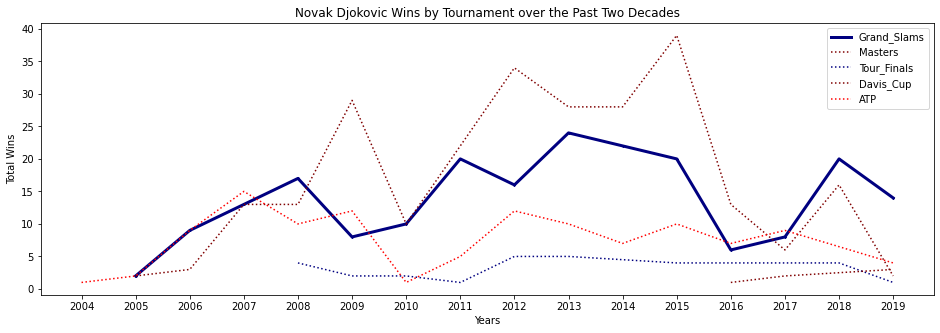

In [216]:
rf1 = df[(df['winner'] == 'Novak Djokovic')].groupby(['year','tourney_level'], as_index=False).agg(['count'])
rf2 = rf1['tourney_id'].reset_index()

fig = plt.figure(figsize=(16,5))
ax = fig.add_subplot(1,1,1)
#jet = cm = plt.get_cmap('jet')

ax.set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, 2, endpoint=True))))
plt.xticks(np.arange(2000, 2020))
plt.title('Novak Djokovic Wins by Tournament over the Past Two Decades')
plt.xlabel("Years")
plt.ylabel("Total Wins")


plt.plot(rf2[rf2['tourney_level']=='G']['year'], rf2[rf2['tourney_level']=='G']['count'], marker='*', markersize=2, linewidth=3)
plt.plot(rf2[rf2['tourney_level']=='M']['year'], rf2[rf2['tourney_level']=='M']['count'], linestyle='dotted')
plt.plot(rf2[rf2['tourney_level']=='F']['year'], rf2[rf2['tourney_level']=='F']['count'], linestyle='dotted')
plt.plot(rf2[rf2['tourney_level']=='D']['year'], rf2[rf2['tourney_level']=='D']['count'], linestyle='dotted')
plt.plot(rf2[rf2['tourney_level']=='A']['year'], rf2[rf2['tourney_level']=='A']['count'], linestyle='dotted', color = "r")
plt.legend(['Grand_Slams', 'Masters', 'Tour_Finals', 'Davis_Cup', 'ATP'], loc='upper right', prop={'size': 10});

In [223]:
df.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,match_num,score,best_of,round,minutes,player_1,player_2,player_1_age,player_2_age,player_1_entry,player_2_entry,player_1_hand,player_2_hand,player_1_ht,player_2_ht,player_1_id,player_2_id,player_1_ioc,player_2_ioc,player_1_name,player_2_name,player_1_rank,player_2_rank,player_1_rank_points,player_2_rank_points,player_1_seed,player_2_seed,player_1_aces,player_2_aces,player_1_double_faults,player_2_double_faults,player_1_service_points,player_2_service_points,player_1_first_serves_in,player_2_first_serves_in,player_1_first_serve_points_won,player_2_first_serve_points_won,player_1_second_serve_points_won,player_2_second_serve_points_won,player_1_service_game_total,player_2_service_game_total,player_1_break_points_saved,player_2_break_points_saved,player_1_break_points_faced,player_2_break_points_faced,winner,player_1_first_serve_%,player_2_first_serve_%,player_1_first_serve_win_%,player_2_first_serve_win_%,player_1_break_points_won,player_2_break_points_won,player_1_wins,surface_Carpet,surface_Clay,surface_Grass,surface_Hard,tourney_level_A,tourney_level_D,tourney_level_F,tourney_level_G,tourney_level_M,player_1_hand_L,player_1_hand_R,player_2_hand_L,player_2_hand_R,round_ER,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF,winner_rank,loser_rank,ht_diff,age_diff,rank_diff,rank_points_diff,no_upset,year
tourney_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-01-11,1999-338,Sydney,Hard,32,A,16,7-6(1) 6-1,3,R32,84.0,Lleyton Hewitt,Patrick Rafter,17.878166,26.036961,NaN,NaN,R,R,180.0,185.0,103720,102158,AUS,AUS,Lleyton Hewitt,Patrick Rafter,104.0,4.0,456.0,3315.0,NaN,2.0,2.0,0.0,0.0,5.0,73.0,59.0,51.0,36.0,32.0,24.0,14.0,8.0,10.0,9.0,4.0,3.0,6.0,7.0,Lleyton Hewitt,0.698630,0.610169,0.627451,0.666667,4.0,2.0,True,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,104.0,4.0,-5.0,-8.158795,100.0,-2859.0,False,1999
1999-01-11,1999-338,Sydney,Hard,32,A,15,5-7 6-3 6-2,3,R32,115.0,Martin Damm Sr,Nicolas Kiefer,26.444901,21.519507,Q,NaN,R,R,188.0,183.0,210013,103017,CZE,GER,Martin Damm Sr,Nicolas Kiefer,75.0,36.0,657.0,1007.0,NaN,NaN,8.0,6.0,2.0,4.0,84.0,86.0,52.0,38.0,40.0,31.0,11.0,32.0,14.0,15.0,3.0,2.0,6.0,3.0,Nicolas Kiefer,0.619048,0.441860,0.769231,0.815789,1.0,3.0,False,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,36.0,75.0,5.0,4.925394,39.0,-350.0,True,1999
1999-01-11,1999-338,Sydney,Hard,32,A,14,6-2 6-4,3,R32,61.0,Jan Siemerink,Mariano Puerta,28.744695,20.312115,NaN,NaN,L,L,183.0,180.0,101733,103264,NED,ARG,Jan Siemerink,Mariano Puerta,19.0,38.0,1664.0,983.0,NaN,NaN,1.0,1.0,7.0,1.0,51.0,46.0,24.0,31.0,15.0,25.0,14.0,11.0,9.0,9.0,3.0,0.0,6.0,0.0,Mariano Puerta,0.470588,0.673913,0.625000,0.806452,0.0,3.0,False,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,38.0,19.0,3.0,8.432580,-19.0,681.0,False,1999
1999-01-11,1999-338,Sydney,Hard,32,A,13,6-1 6-3,3,R32,43.0,Hicham Arazi,Todd Martin,25.229295,28.511978,NaN,NaN,L,R,175.0,198.0,102271,101774,MAR,USA,Hicham Arazi,Todd Martin,34.0,16.0,1069.0,1774.0,NaN,8.0,2.0,10.0,3.0,0.0,47.0,36.0,27.0,27.0,16.0,25.0,6.0,7.0,8.0,8.0,1.0,0.0,5.0,0.0,Todd Martin,0.574468,0.750000,0.592593,0.925926,0.0,4.0,False,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,16.0,34.0,-23.0,-3.282683,18.0,-705.0,True,1999
1999-01-11,1999-338,Sydney,Hard,32,A,12,6-3 7-6(4),3,R32,85.0,Carlos Moya,Thomas Johansson,22.373717,23.802875,NaN,NaN,R,R,190.0,180.0,102845,102563,ESP,SWE,Carlos Moya,Thomas Johansson,5.0,17.0,3159.0,1761.0,3.0,NaN,7.0,8.0,1.0,2.0,79.0,58.0,37.0,26.0,28.0,19.0,22.0,17.0,11.0,10.0,5.0,2.0,7.0,5.0,Carlos Moya,0.468354,0.448276,0.756757,0.730769,3.0,2.0,True,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,5.0,17.0,10.0,-1.429158,-12.0,1398.0,True,1999


In [222]:
#df.head()
# rival_50 = PD_merge_50[PD_merge_50.Player_Name_x.isin(player_list)]
# rival_50

player_list = ['Roger Federer', 'Andy Roddick', 'Rafael Nadal', 'Novak Djokovic', 'Andy Murray']
FR = df[df]

In [220]:
FR = Fed_Rivalry
FR.columns = FR.iloc[2]
FR

2003-08-04 00:00:00,2003-421,Canada Masters,Hard,64,M,62,6-4 3-6 7-6(3),3,SF,116.0,Andy Roddick,Roger Federer,20.9281314168,21.9876796715,NaN,NaN,R,R,188.0,185.0,104053,103819,USA,SUI,Andy Roddick,Roger Federer,7.0,3.0,2630.0,3690.0,6.0,3.0,9.0,9.0,2.0,10.0,85.0,100.0,41.0,56.0,32.0,47.0,28.0,19.0,15.0,16.0,0.0,7.0,2.0,9.0,Andy Roddick,0.4823529411764706,0.56,0.7804878048780488,0.8392857142857143,2.0,2.0,True,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,7.0,3.0,3.0,-1.059548254700001,4.0,-1060.0,False,2003
tourney_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-10-22,2001-328,Basel,Carpet,32,A,26,3-6 6-3 7-6(5),3,QF,101.0,Andy Roddick,Roger Federer,19.145791,20.205339,NaN,NaN,R,R,188.0,185.0,104053,103819,USA,SUI,Andy Roddick,Roger Federer,16.0,13.0,1610.0,1745.0,6.0,4.0,9.0,11.0,1.0,2.0,93.0,84.0,54.0,51.0,41.0,43.0,22.0,18.0,15.0,15.0,4.0,1.0,6.0,3.0,Roger Federer,0.580645,0.607143,0.759259,0.843137,2.0,2.0,False,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,13.0,16.0,3.0,-1.059548,3.0,-135.0,True,2001
2003-06-23,2003-540,Wimbledon,Grass,128,G,125,7-6(6) 6-3 6-3,5,SF,103.0,Andy Roddick,Roger Federer,20.813142,21.872690,NaN,NaN,R,R,188.0,185.0,104053,103819,USA,SUI,Andy Roddick,Roger Federer,6.0,5.0,2390.0,2580.0,5.0,4.0,4.0,17.0,0.0,0.0,99.0,84.0,57.0,51.0,42.0,42.0,21.0,25.0,15.0,15.0,5.0,2.0,8.0,2.0,Roger Federer,0.575758,0.607143,0.736842,0.823529,0.0,3.0,False,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,5.0,6.0,3.0,-1.059548,1.0,-190.0,True,2003
2003-08-04,2003-421,Canada Masters,Hard,64,M,62,6-4 3-6 7-6(3),3,SF,116.0,Andy Roddick,Roger Federer,20.928131,21.987680,NaN,NaN,R,R,188.0,185.0,104053,103819,USA,SUI,Andy Roddick,Roger Federer,7.0,3.0,2630.0,3690.0,6.0,3.0,9.0,9.0,2.0,10.0,85.0,100.0,41.0,56.0,32.0,47.0,28.0,19.0,15.0,16.0,0.0,7.0,2.0,9.0,Andy Roddick,0.482353,0.560000,0.780488,0.839286,2.0,2.0,True,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,7.0,3.0,3.0,-1.059548,4.0,-1060.0,False,2003
2003-11-10,2003-605,Masters Cup,Hard,8,F,4,7-6(2) 6-2,3,SF,62.0,Andy Roddick,Roger Federer,21.196441,22.255989,NaN,NaN,R,R,188.0,185.0,104053,103819,USA,SUI,Andy Roddick,Roger Federer,1.0,3.0,4335.0,3625.0,NaN,NaN,5.0,12.0,1.0,2.0,63.0,56.0,46.0,31.0,34.0,27.0,6.0,19.0,10.0,10.0,0.0,0.0,2.0,0.0,Roger Federer,0.730159,0.553571,0.739130,0.870968,0.0,2.0,False,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,3.0,1.0,3.0,-1.059548,-2.0,710.0,False,2003
2004-06-21,2004-540,Wimbledon,Grass,128,G,127,4-6 7-5 7-6(3) 6-4,5,F,151.0,Andy Roddick,Roger Federer,21.809719,22.869268,NaN,NaN,R,R,188.0,185.0,104053,103819,USA,SUI,Andy Roddick,Roger Federer,2.0,1.0,4695.0,5610.0,2.0,1.0,11.0,12.0,5.0,3.0,133.0,154.0,81.0,95.0,60.0,64.0,21.0,34.0,22.0,22.0,5.0,10.0,10.0,14.0,Roger Federer,0.609023,0.616883,0.740741,0.673684,4.0,5.0,False,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1.0,2.0,3.0,-1.059548,1.0,-915.0,True,2004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-11-05,2012-605,Tour Finals,Hard,8,F,514,7-6(5) 6-2,3,SF,94.0,Andy Murray,Roger Federer,25.478439,31.244353,NaN,NaN,R,R,190.0,185.0,104918,103819,GBR,SUI,Andy Murray,Roger Federer,3.0,2.0,7600.0,9465.0,3.0,2.0,5.0,2.0,1.0,0.0,66.0,59.0,31.0,32.0,25.0,27.0,15.0,17.0,10.0,10.0,0.0,1.0,3.0,2.0,Roger Federer,0.469697,0.542373,0.806452,0.843750,1.0,3.0,False,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,2.0,3.0,5.0,-5.765914,1.0,-1865.0,True,2012
2013-01-14,2013-580,Australian Open,Hard,128,G,126,6-4 6-7(5) 6-3 6-7(2) 6-2,5,SF,240.0,Andy Murray,Roger Federer,25.670089,31.436003,NaN,NaN,R,R,190.0,185.0,104918,103819,GBR,SUI,Andy Murray,Roger Federer,3.0,2.0,8000.0,10265.0,3.0,2.0,21.0,5.0,0.0,2.0,157.0,171.0,100.0,106.0,75.0,77.0,36.0,28.0,26.

60 - 64

<ipython-input-88-b5e9aa5b159a>:12: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  ax1.pie(values, labels=labels, autopct='%.0f%%', colors=['#dfff4f', '#3C638E'])
<ipython-input-88-b5e9aa5b159a>:20: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  ax2.pie(values, labels=labels, autopct='%.0f%%', colors=['#dfff4f', '#3C638E'])


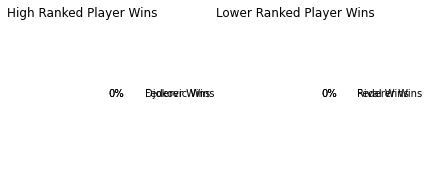

In [89]:
get_pies_upsets_fed_v_riv()

---- Filter for rank 23-80